# Random Forest Guided Example Practice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data

In [2]:
y2015 = pd.read_csv('loan_stats.csv',skipinitialspace=True,header=1)

/Users/wliao/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [4]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

In [5]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [ ]:
pd.get_dummies(y2015)
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

## Model Data

In [8]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([ 0.97981525,  0.98059889,  0.98124006,  0.98173874,  0.9710995 ,
        0.97744004,  0.9628583 ,  0.98050298,  0.98026456,  0.9801216 ])

## Feature consolidation

Most of the variance appears to be explained within the first component, so we modeled with the first component. Still, the performance appears to be poor. 

### PCA

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=5)

X_pca = sklearn_pca.fit_transform(X)

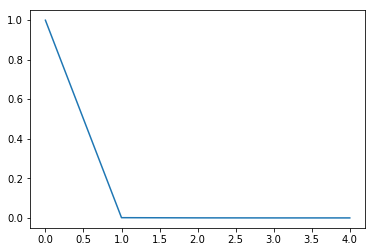

In [20]:
plt.plot(sklearn_pca.explained_variance_ratio_)

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=1)

X_pca = sklearn_pca.fit_transform(X)

In [25]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X_pca, Y, cv=10)

array([ 0.68105721,  0.20633564,  0.14476028,  0.12685522,  0.10980765,
        0.11049632,  0.08264267,  0.08831841,  0.11071793,  0.25191184])

###  Mutual info classif

With this feature selection approach, we were able to reduce the features by 90% and still yield accuracy above 90%. 

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

# Initialize SelectKBest 
selector = SelectKBest(mutual_info_classif,k=10)

# Fit to data
selector.fit(X, Y)

# Store columns returned from filtering
idxs_selected = selector.get_support(indices=True)
result = X[X.columns[[idxs_selected]]]

In [23]:
result.head()

,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,last_pymnt_d_Jan-2017,next_pymnt_d_Feb-2017,last_credit_pull_d_Jan-2017
0,13668.88,13668.88,4519.68,4519.68,2331.12,2188.56,379.39,1,0,1
1,6635.69,6635.69,3572.97,3572.97,2964.31,608.66,298.58,1,0,1
2,0.00,0.00,26224.23,26224.23,25000.00,1224.23,20807.39,0,0,1
3,19263.77,19263.77,10271.36,10271.36,8736.23,1535.13,858.05,1,0,1
4,0.00,0.00,9190.49,9190.49,8650.00,540.49,8251.42,0,0,0


In [26]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# Initialize random forest classifier
rfc = ensemble.RandomForestClassifier()

# Store results from cross validation
scores = cross_val_score(rfc, result, Y, cv=10)

In [27]:
scores.mean()

0.93882394671199321